# This is breast cancer classification project
**Information about data can be found in "SEER Breast Cancer Dataset.pdf" file**

### Analysis is divided in several parts:
* [Data reading and cleaning](#Data-reading-and-cleaning)
* [EDA + Visualizations](#EDA-+-Visualizations)
* [Models](#Models)

In [1]:
# some base imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# additional imports
import sys
first_steps_path = r"..\utils\common_utils"
if first_steps_path not in sys.path:
    sys.path.append(first_steps_path)
from first_steps import first_descriptions
# some basic settings
pd.set_option('display.max_columns', 100)

plt.style.use('seaborn-v0_8-deep')

%load_ext autoreload
%autoreload 2

# Data reading and cleaning

In [2]:
cancer_raw_data = pd.read_csv("SEER Breast Cancer Dataset .csv")
# there are mistake in data, so it has fully-nulled column, so we drop it
cancer_raw_data = cancer_raw_data.drop('Unnamed: 3', axis = 1)

In [3]:
first_descriptions(cancer_raw_data)

************************************************* Dataset first description **************************************************
****************************************************** Head of dataset *******************************************************


,Age,Race,Marital Status,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,43,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),T2,N3,IIIC,Moderately differentiated; Grade II,Regional,40,Positive,Positive,19,11,1,Alive
1,47,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),T2,N2,IIIA,Moderately differentiated; Grade II,Regional,45,Positive,Positive,25,9,2,Alive
2,67,White,Married (including common law),T2,N1,IIB,Poorly differentiated; Grade III,Regional,25,Positive,Positive,4,1,2,Dead
3,46,White,Divorced,T1,N1,IIA,Moderately differentiated; Grade II,Regional,19,Positive,Positive,26,1,2,Dead
4,63,White,Married (including common law),T2,N2,IIIA,Moderately differentiated; Grade II,Regional,35,Positive,Positive,21,5,3,Dead


*************************************************** Pandas-Generated info ****************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   Grade                   4024 non-null   object
 7   A Stage                 4024 non-null   object
 8   Tumor Size              4024 non-null   int64 
 9   Estrogen Status         4024 non-null   object
 10  Progesterone Status     4024 non-null   object
 11  Regional Node Examined  4024 non-null   int64 
 12  Reginol Node Positive   4024 non-

None

************************************************ Categorical features unique *************************************************
Race 
['Other (American Indian/AK Native, Asian/Pacific Islander)' 'White'
 'Black'] 

Marital Status
['Married (including common law)' 'Divorced' 'Single (never married)'
 'Widowed' 'Separated'] 

T Stage 
['T2' 'T1' 'T3' 'T4'] 

N Stage
['N3' 'N2' 'N1'] 

6th Stage
['IIIC' 'IIIA' 'IIB' 'IIA' 'IIIB'] 

Grade
['Moderately differentiated; Grade II' 'Poorly differentiated; Grade III'
 'Well differentiated; Grade I' 'Undifferentiated; anaplastic; Grade IV'] 

A Stage
['Regional' 'Distant'] 

Estrogen Status
['Positive' 'Negative'] 

Progesterone Status
['Positive' 'Negative'] 

Status
['Alive' 'Dead'] 

****************************************************** Dublicate check *******************************************************
Number of dublicates is : 1
********************************************************* NaN check ******************************************

### Data cleaning plan:
* **Seems like we have single dublicate, we'll delete it**  
* **Some categorical features can be transformed in 0 or 1**  
* **We'll separate data from target column** 
* **Columns need some renaming**
* **Some categorical features need better naming e.g. stage names can be shorten**

In [4]:
# drop dublicates
cancer_raw_data = cancer_raw_data.drop_duplicates()
assert cancer_raw_data.duplicated().sum() == 0

In [5]:
# boolean columns transform
boolean_columns = [
    'Estrogen Status',
    'Progesterone Status'
]
for column in boolean_columns:
    cancer_raw_data[column] = pd.to_numeric(cancer_raw_data[column].apply(lambda x: 1 if x=='Positive' else 0))

In [6]:
# target transform
target = pd.to_numeric(cancer_raw_data['Status'].apply(lambda x: 1 if x=='Dead' else 0))
cancer_raw_data['Status'] = pd.to_numeric(cancer_raw_data['Status'].apply(lambda x: 1 if x=='Dead' else 0))

In [7]:
# columns renaming
cancer_raw_data.columns = [
    'age',
    'race',
    'mariage',
    't_stage',
    'n_stage',
    'sixth_stage',
    'grade',
    'a_stage',
    'tumor_size',
    'estrogen_status',
    'progesterone_status',
    'regional_node_examined',
    'regional_node_positive',
    'survival_month',
    'status'
]

# cat values renaming
cancer_raw_data.race = cancer_raw_data.race.apply(
    lambda x: "Other" if x=='Other (American Indian/AK Native, Asian/Pacific Islander)' else x
)

cancer_raw_data.mariage = cancer_raw_data.mariage.apply(
    lambda x: "Married" if x == 'Married (including common law)' 
    else "Single" if x == 'Single (never married)' else x
)

cancer_raw_data.grade = cancer_raw_data.grade.apply(
    lambda x: 
    "I" if x=='Well differentiated; Grade I' else
    "II" if x=='Moderately differentiated; Grade II' else
    "III" if x=='Poorly differentiated; Grade III' else
    "IV" if x=='Undifferentiated; anaplastic; Grade IV' else x
)

In [8]:
cancer_data = cancer_raw_data.copy()

# EDA + Visualizations

### First check distribution of target

In [9]:
target.value_counts()

0    3407
1     616
Name: Status, dtype: int64

**Looks like we have unbalanced classes  
In that case we'll learn and apply some techniques to fix it further on in modeling**

### Let's plot feature distributions

In [10]:
numerical_features = [
    'age',
    'tumor_size',
    'regional_node_examined',
    'regional_node_positive',
    'survival_month',
]
categorical_features = [
    'race',
    'mariage',
    't_stage',
    'n_stage',
    'sixth_stage',
    'grade',
    'a_stage',
    'estrogen_status',
    'progesterone_status',
]
print(len(categorical_features))
print(len(numerical_features))

9
5


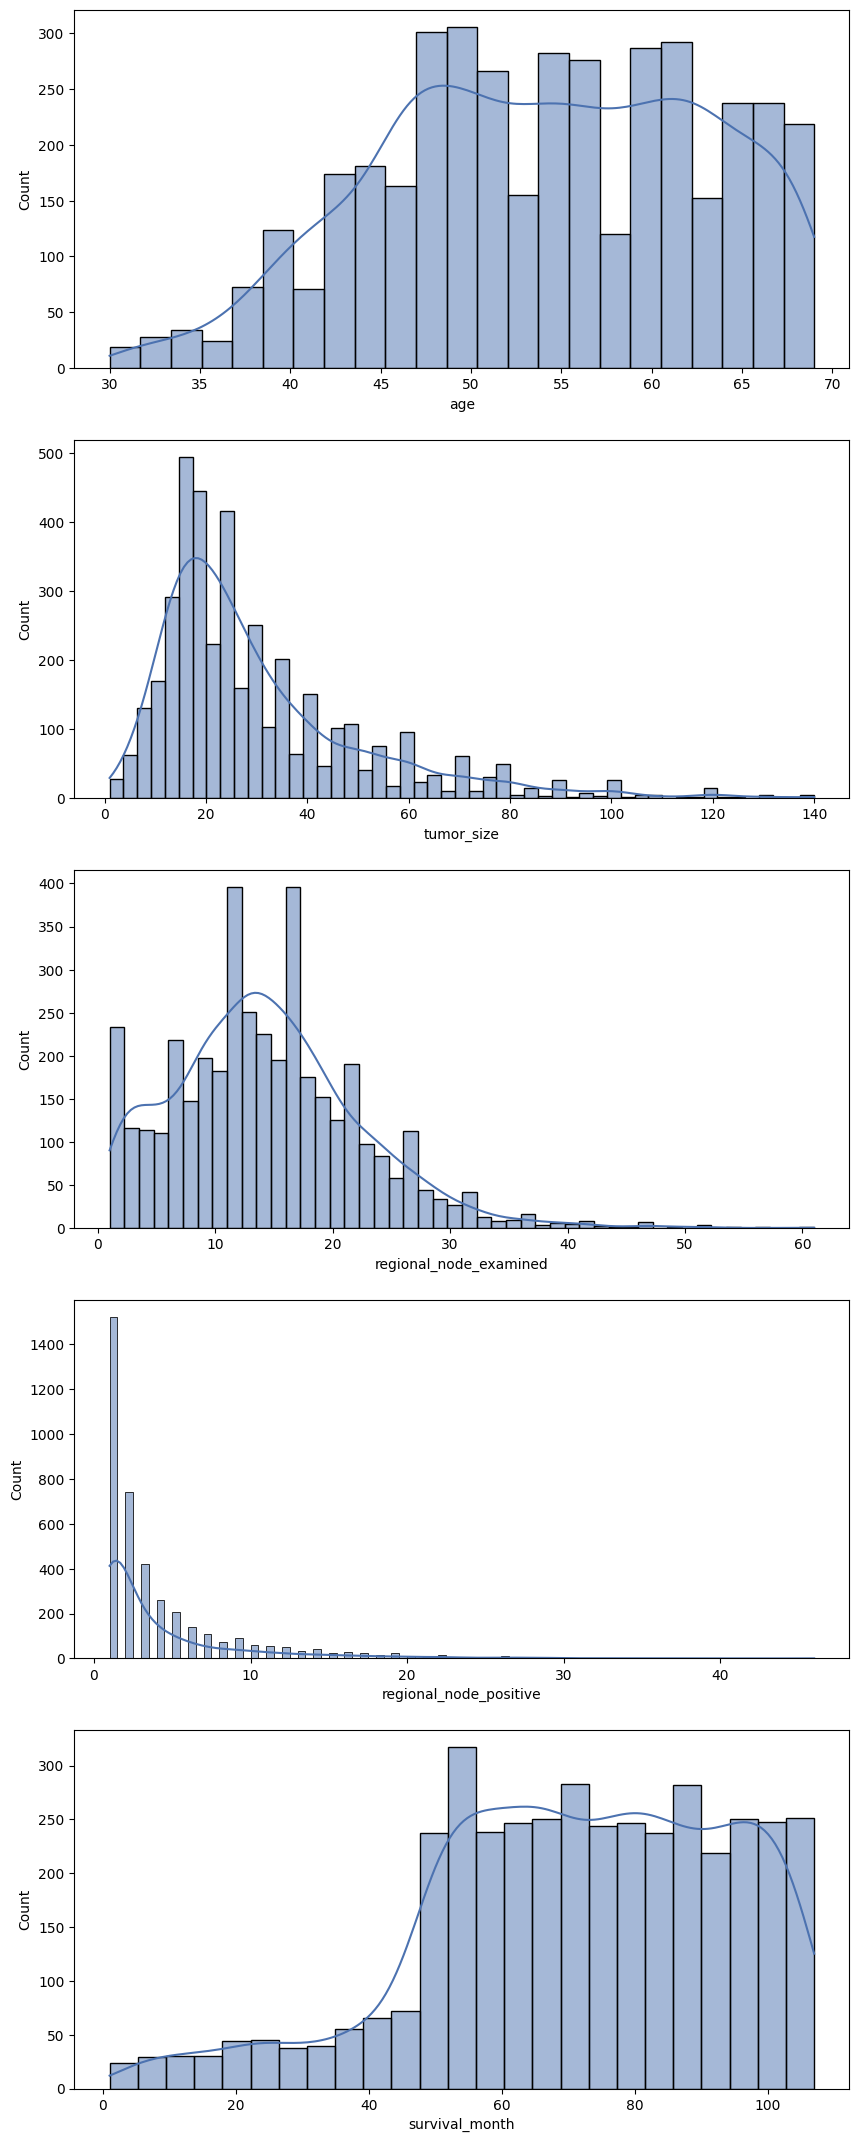

In [11]:
fig, ax = plt.subplots(5, 1, figsize=(10,27))
for i, axs in enumerate(ax.flatten()):
    sns.histplot(cancer_data[numerical_features[i]], ax=axs, kde=True)

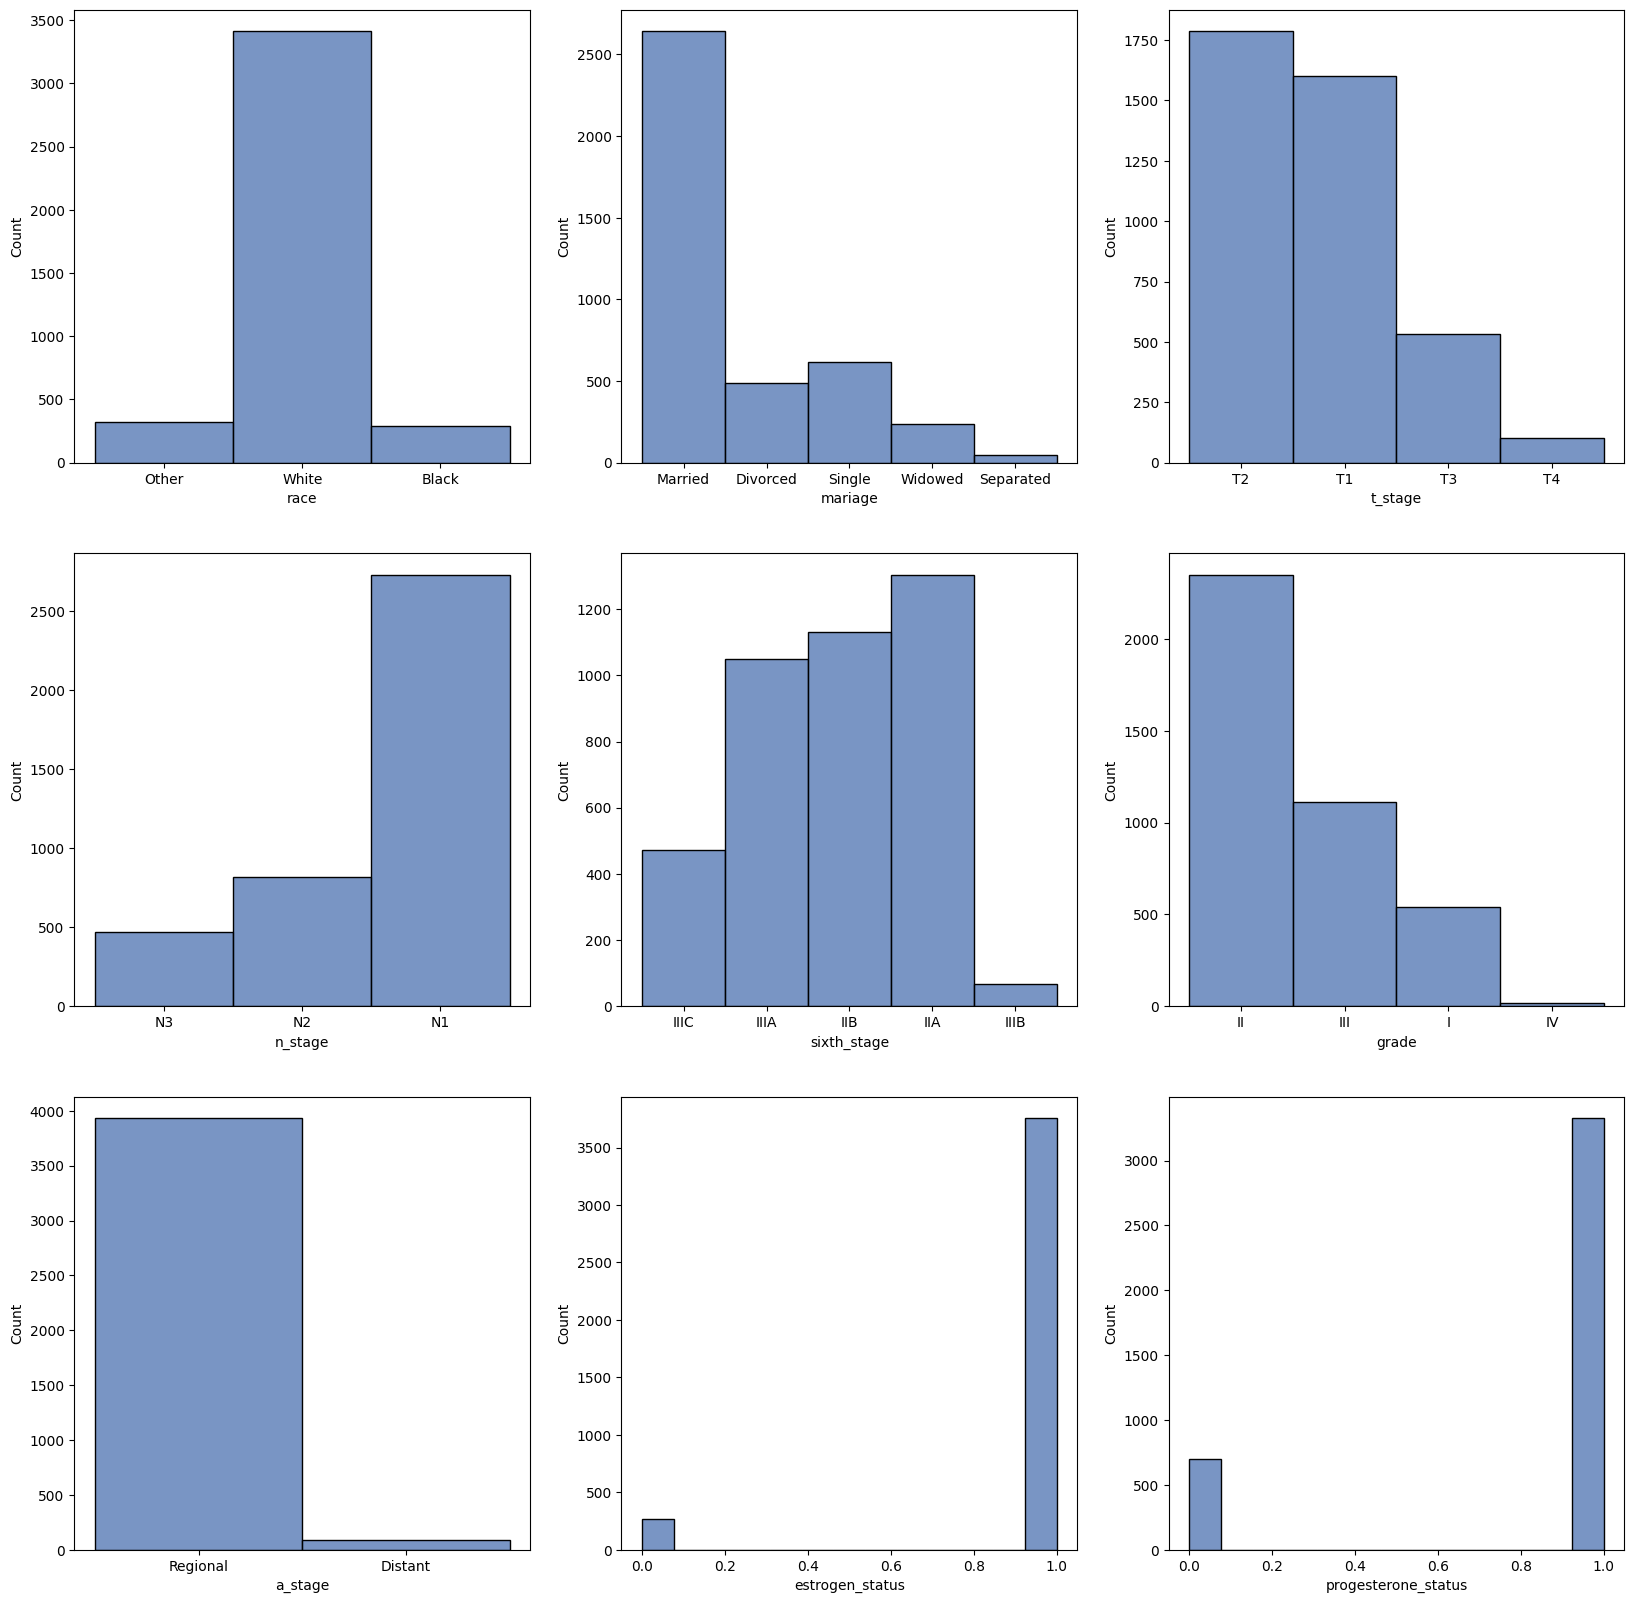

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(20,20))
for i, axs in enumerate(ax.flatten()):
    sns.histplot(cancer_data[categorical_features[i]], ax=axs)

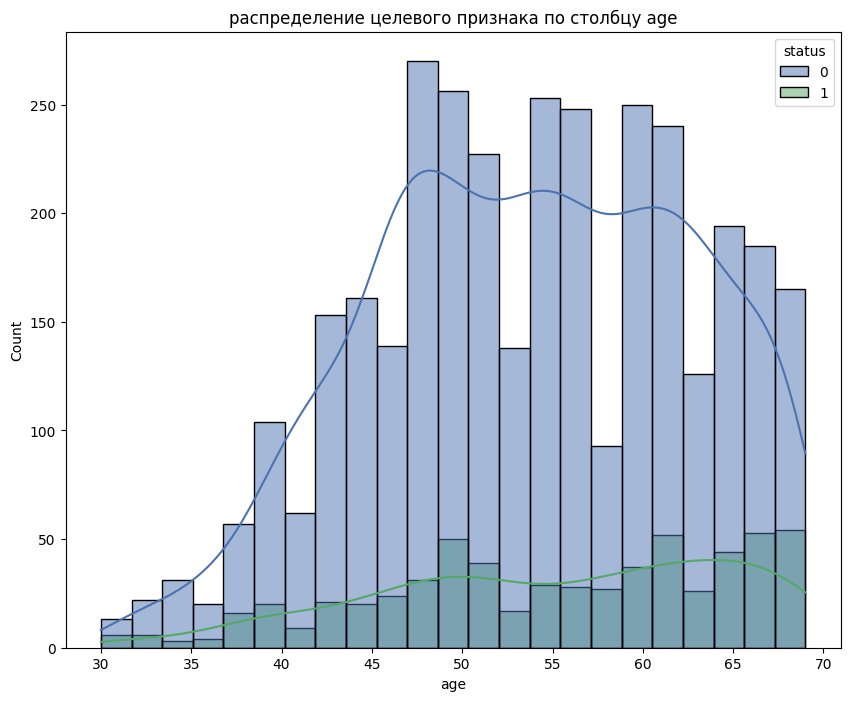

Описательные статистики по столбцу age в зависимости от статуса


,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
0,3407.0,53.756384,8.808290,30.0,47.0,54.0,61.0,69.0
1,616.0,55.150974,9.698291,30.0,48.0,56.5,63.0,69.0


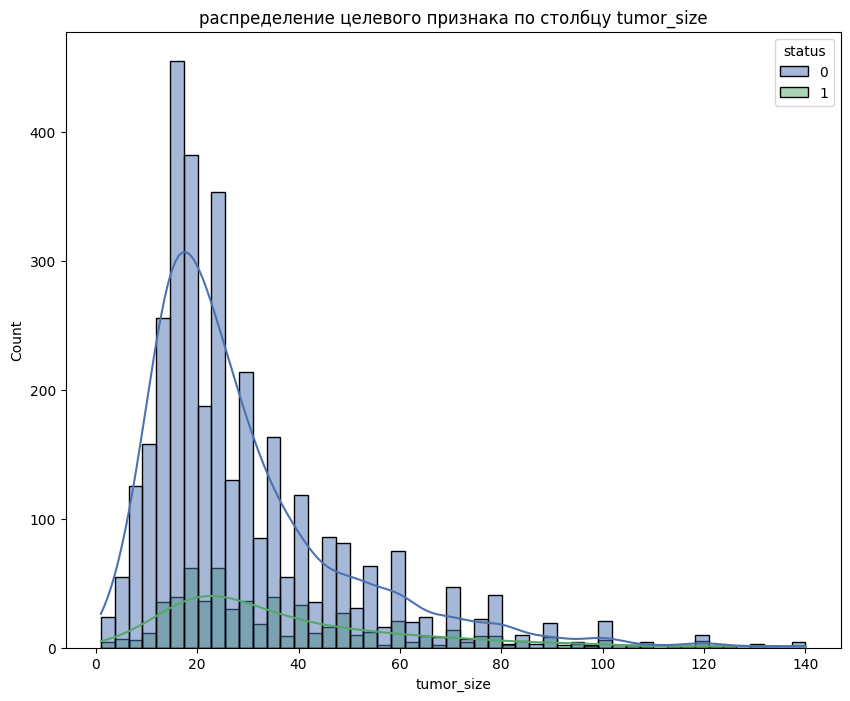

Описательные статистики по столбцу tumor_size в зависимости от статуса


,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
0,3407.0,29.27238,20.305066,1.0,15.0,23.0,35.0,140.0
1,616.0,37.13961,24.116115,1.0,20.0,30.0,50.0,140.0


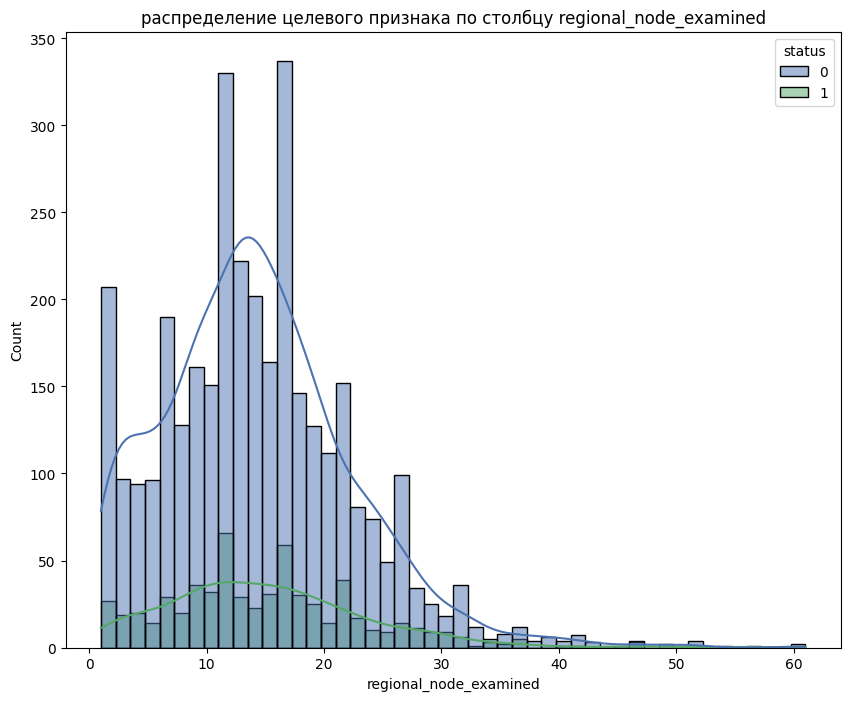

Описательные статистики по столбцу regional_node_examined в зависимости от статуса


,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
0,3407.0,14.238920,8.023884,1.0,9.0,14.0,19.0,61.0
1,616.0,15.019481,8.486600,1.0,9.0,14.0,20.0,57.0


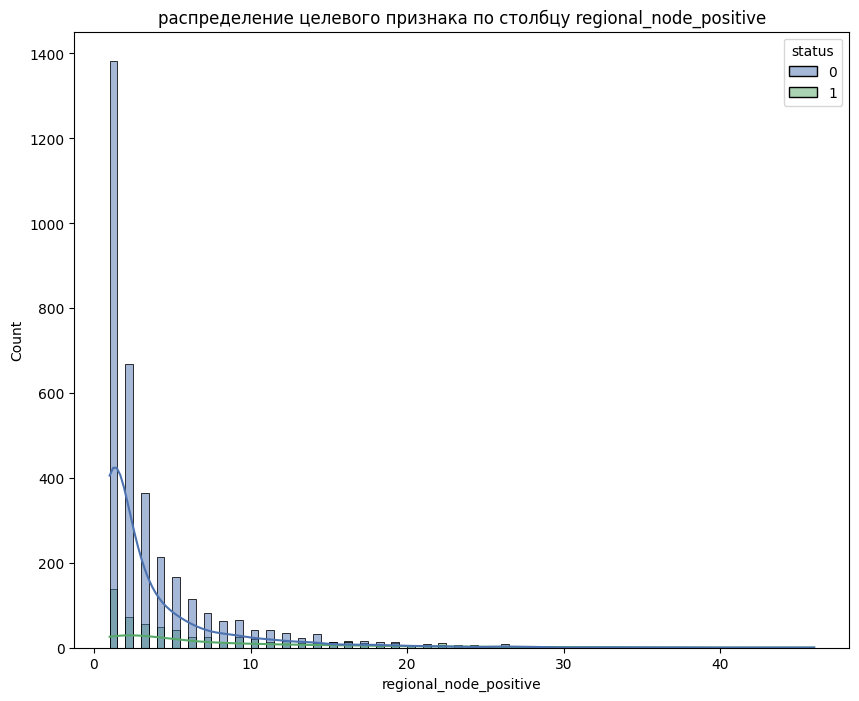

Описательные статистики по столбцу regional_node_positive в зависимости от статуса


,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
0,3407.0,3.601409,4.375595,1.0,1.0,2.0,4.0,41.0
1,616.0,7.241883,7.312642,1.0,2.0,4.0,10.0,46.0


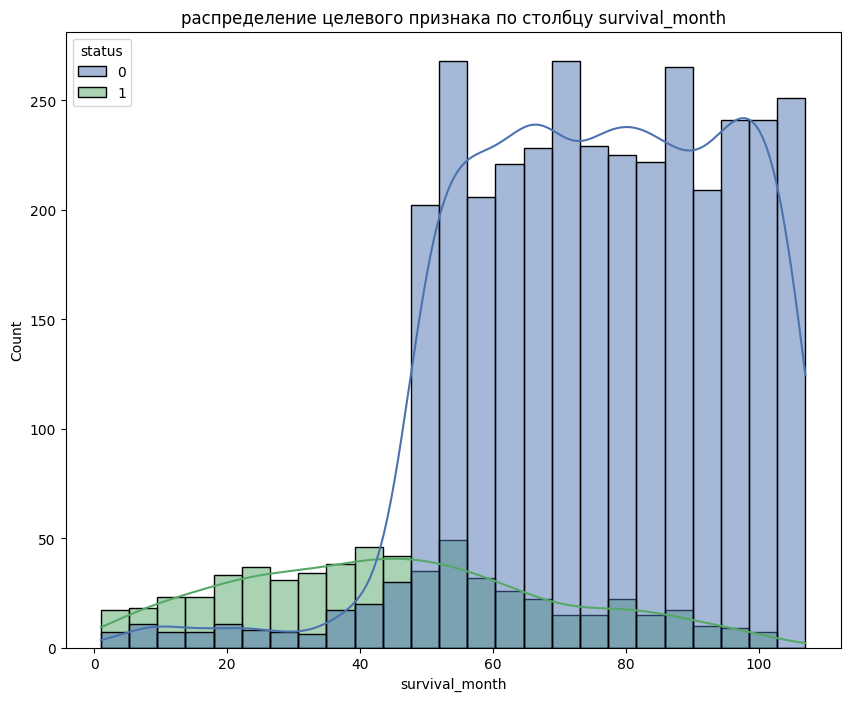

Описательные статистики по столбцу survival_month в зависимости от статуса


,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
0,3407.0,75.946874,19.386293,1.0,61.0,77.0,92.0,107.0
1,616.0,45.610390,23.966253,2.0,27.0,44.0,61.0,102.0


In [13]:
for i, feature in enumerate(numerical_features):
    fig, ax = plt.subplots(1, 1, figsize=(10,8))
    sns.histplot(
        data=cancer_data, 
        x=feature, 
        ax=ax, 
        hue='status',
        kde=True
    )
    ax.set_title(f"распределение целевого признака по столбцу {feature}")
    plt.show()
    print(f"Описательные статистики по столбцу {feature} в зависимости от статуса")
    display(
        cancer_data.groupby('status')[feature].describe()
    )

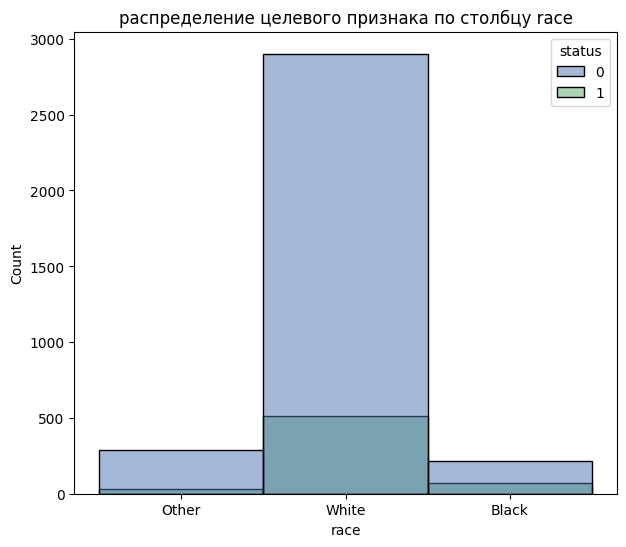

Распределение целевой пременной в зависимости от race


race   status
Black  0          218
       1           73
Other  0          287
       1           33
White  0         2902
       1          510
Name: status, dtype: int64

Распределение целевой пременной в зависимости от race в процентах


race   status
Black  0         0.749141
       1         0.250859
Other  0         0.896875
       1         0.103125
White  0         0.850528
       1         0.149472
Name: status, dtype: float64

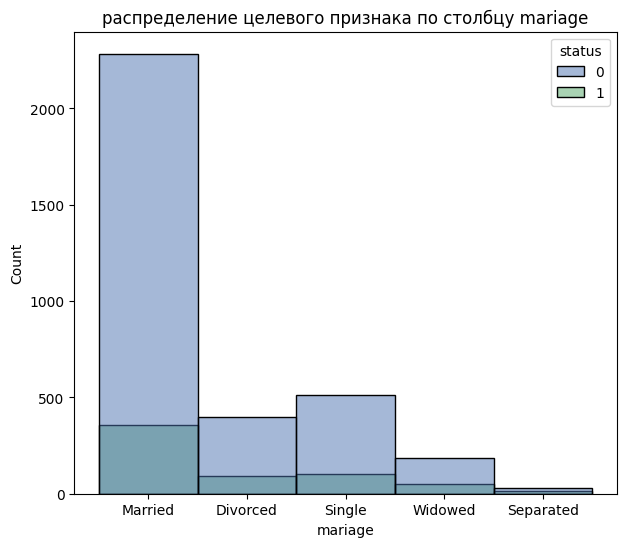

Распределение целевой пременной в зависимости от mariage


mariage    status
Divorced   0          396
           1           90
Married    0         2284
           1          358
Separated  0           30
           1           15
Single     0          511
           1          104
Widowed    0          186
           1           49
Name: status, dtype: int64

Распределение целевой пременной в зависимости от mariage в процентах


mariage    status
Divorced   0         0.814815
           1         0.185185
Married    0         0.864497
           1         0.135503
Separated  0         0.666667
           1         0.333333
Single     0         0.830894
           1         0.169106
Widowed    0         0.791489
           1         0.208511
Name: status, dtype: float64

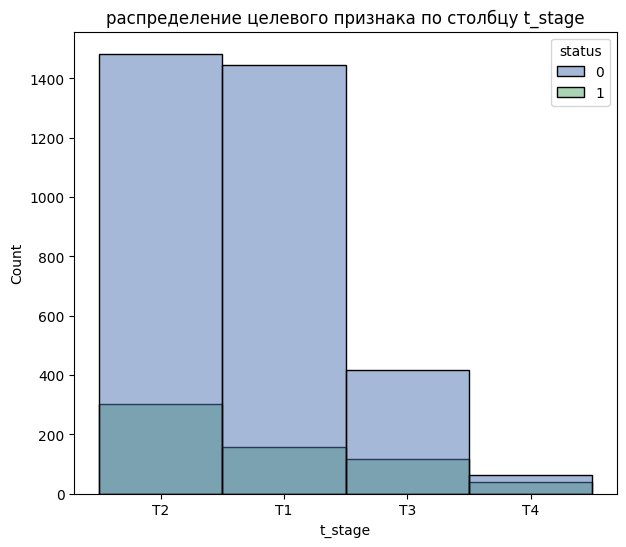

Распределение целевой пременной в зависимости от t_stage


t_stage  status
T1       0         1445
         1          157
T2       0         1483
         1          303
T3       0          417
         1          116
T4       0           62
         1           40
Name: status, dtype: int64

Распределение целевой пременной в зависимости от t_stage в процентах


t_stage  status
T1       0         0.901998
         1         0.098002
T2       0         0.830347
         1         0.169653
T3       0         0.782364
         1         0.217636
T4       0         0.607843
         1         0.392157
Name: status, dtype: float64

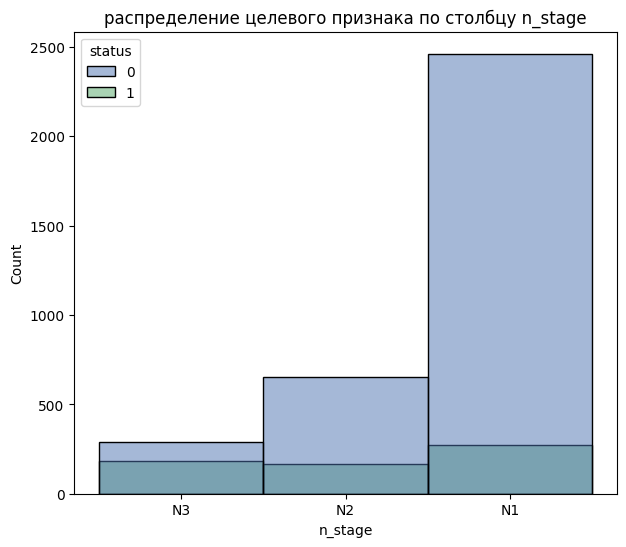

Распределение целевой пременной в зависимости от n_stage


n_stage  status
N1       0         2461
         1          270
N2       0          655
         1          165
N3       0          291
         1          181
Name: status, dtype: int64

Распределение целевой пременной в зависимости от n_stage в процентах


n_stage  status
N1       0         0.901135
         1         0.098865
N2       0         0.798780
         1         0.201220
N3       0         0.616525
         1         0.383475
Name: status, dtype: float64

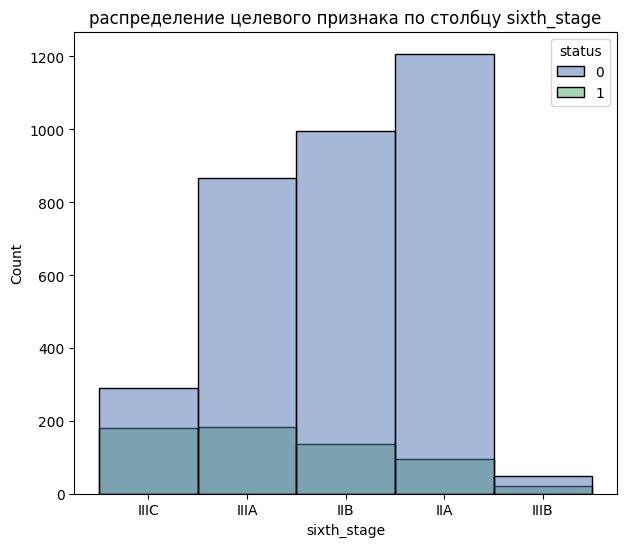

Распределение целевой пременной в зависимости от sixth_stage


sixth_stage  status
IIA          0         1208
             1           96
IIB          0          995
             1          135
IIIA         0          866
             1          184
IIIB         0           47
             1           20
IIIC         0          291
             1          181
Name: status, dtype: int64

Распределение целевой пременной в зависимости от sixth_stage в процентах


sixth_stage  status
IIA          0         0.926380
             1         0.073620
IIB          0         0.880531
             1         0.119469
IIIA         0         0.824762
             1         0.175238
IIIB         0         0.701493
             1         0.298507
IIIC         0         0.616525
             1         0.383475
Name: status, dtype: float64

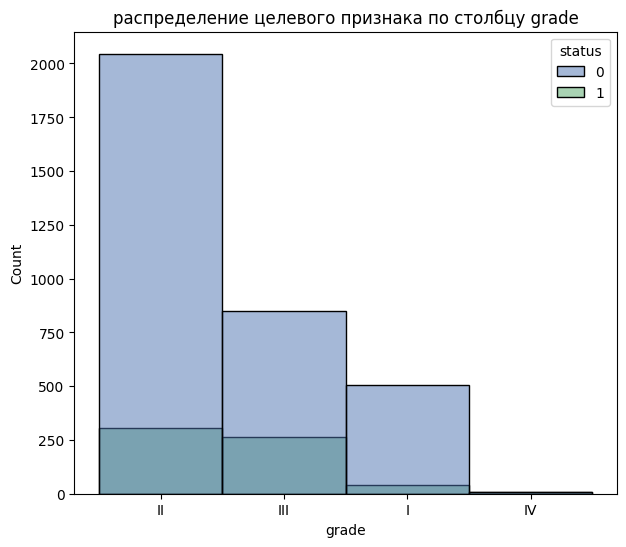

Распределение целевой пременной в зависимости от grade


grade  status
I      0          504
       1           39
II     0         2045
       1          305
III    0          848
       1          263
IV     0           10
       1            9
Name: status, dtype: int64

Распределение целевой пременной в зависимости от grade в процентах


grade  status
I      0         0.928177
       1         0.071823
II     0         0.870213
       1         0.129787
III    0         0.763276
       1         0.236724
IV     0         0.526316
       1         0.473684
Name: status, dtype: float64

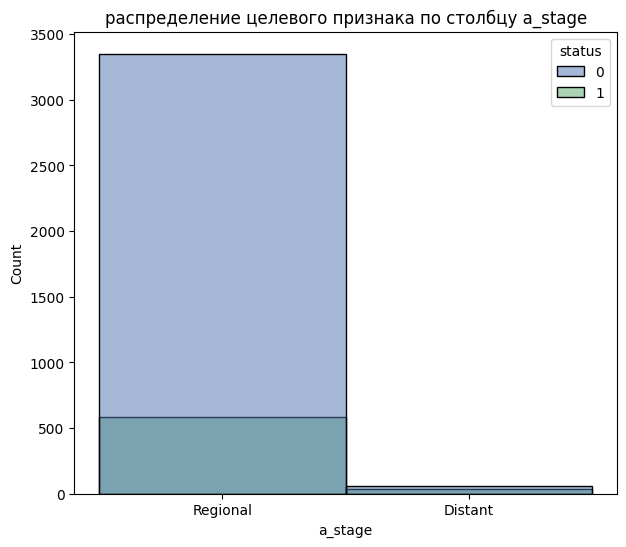

Распределение целевой пременной в зависимости от a_stage


a_stage   status
Distant   0           57
          1           35
Regional  0         3350
          1          581
Name: status, dtype: int64

Распределение целевой пременной в зависимости от a_stage в процентах


a_stage   status
Distant   0         0.619565
          1         0.380435
Regional  0         0.852200
          1         0.147800
Name: status, dtype: float64

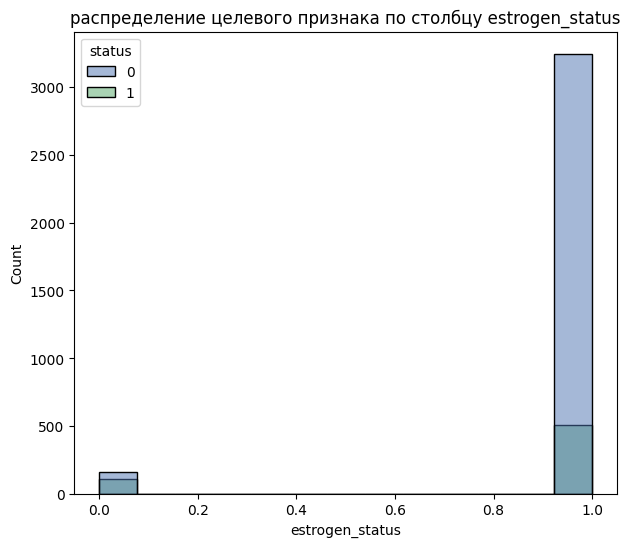

Распределение целевой пременной в зависимости от estrogen_status


estrogen_status  status
0                0          161
                 1          108
1                0         3246
                 1          508
Name: status, dtype: int64

Распределение целевой пременной в зависимости от estrogen_status в процентах


estrogen_status  status
0                0         0.598513
                 1         0.401487
1                0         0.864678
                 1         0.135322
Name: status, dtype: float64

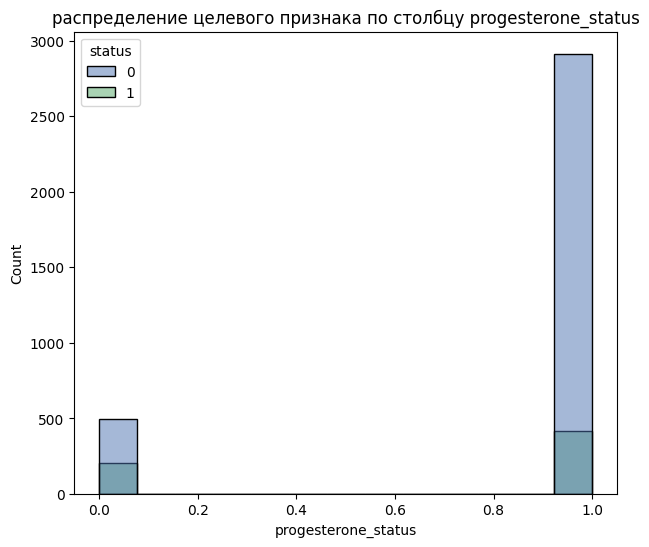

Распределение целевой пременной в зависимости от progesterone_status


progesterone_status  status
0                    0          494
                     1          204
1                    0         2913
                     1          412
Name: status, dtype: int64

Распределение целевой пременной в зависимости от progesterone_status в процентах


progesterone_status  status
0                    0         0.707736
                     1         0.292264
1                    0         0.876090
                     1         0.123910
Name: status, dtype: float64

In [14]:
for i, feature in enumerate(categorical_features):
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    sns.histplot(data=cancer_data, 
                 x=feature, 
                 ax=ax, 
                 hue='status'
                )
    ax.set_title(f"распределение целевого признака по столбцу {feature}")
    plt.show()
    print(f"Распределение целевой пременной в зависимости от {feature}")
    display(
        cancer_data.groupby(feature)['status'].value_counts()
    )
    print(f"Распределение целевой пременной в зависимости от {feature} в процентах")
    display(
        cancer_data.groupby(feature)['status'].value_counts() / cancer_data.groupby(feature)['status'].count()
    )

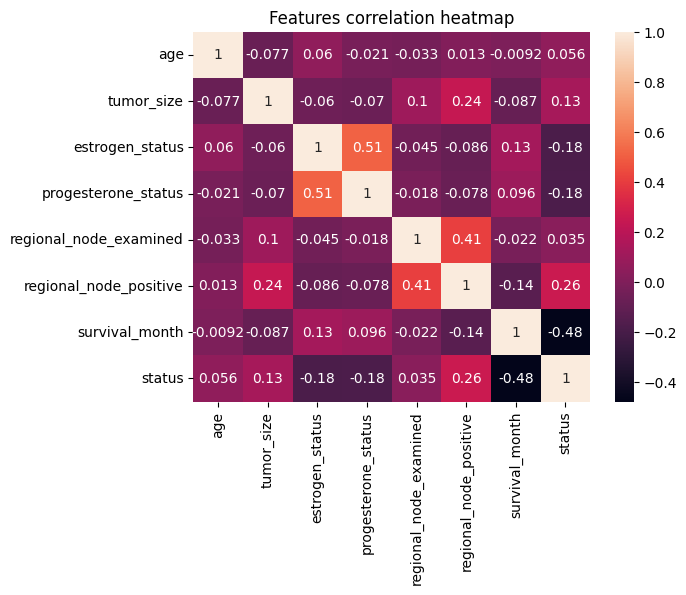

In [15]:
ax = sns.heatmap(
    cancer_data.corr(numeric_only=True), 
    annot=True,
)
ax.set_title("Features correlation heatmap")
None

***Looks like we dont have high-correlated features, so we don't need to drop any column***

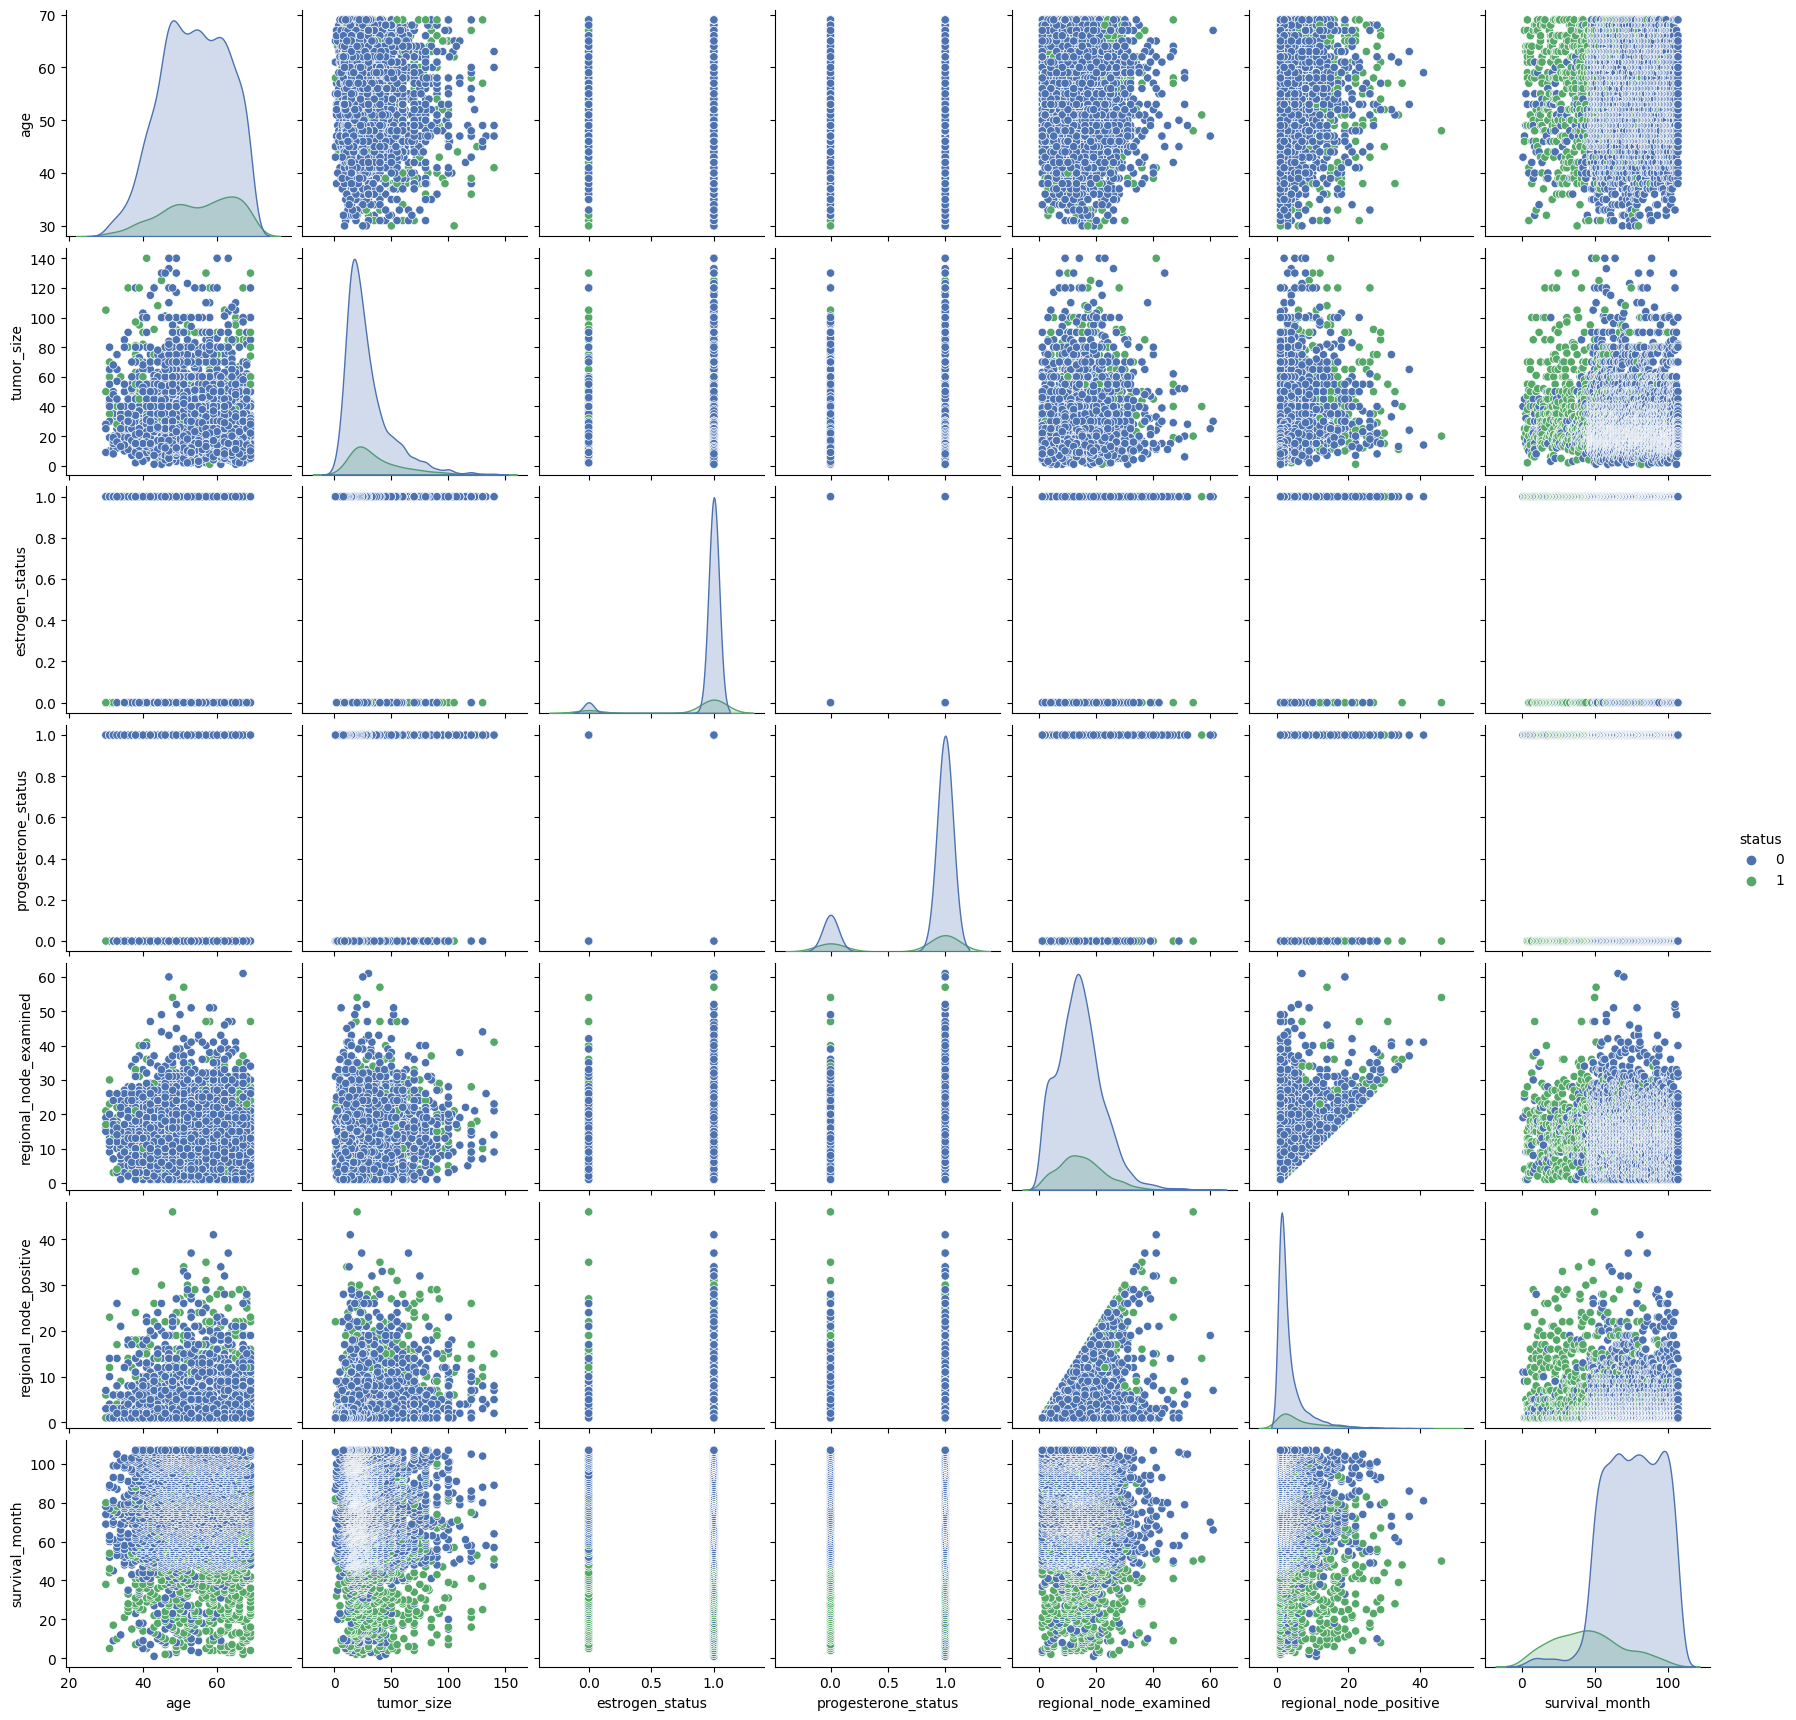

In [16]:
sns.pairplot(data=cancer_data, hue='status')

### EDA summary
1) Chance of surviving highly depends on survival month.  
After research I found that it's calculating like this:  
FLOOR((endpoint – date of diagnosis) / days in a month).  
So basicaly if women was late with diagnostics and, unfortunatley died, this feature will show it.  
Therefore it will not be used for modeling, because it can lead to data leakage.  
2) Women with higher age have more chances to die of breast cancer.  
3) After little research I found that if progesteron and estrogen status is negative cancer if much harder to treat, 
It is shown in this data analisys, because procent of alive women with negative estrogen and progesterone status is lower than with positive. We'll probably need one more column that will discribe both negative estrogen and negative progesterone.

In [17]:
cancer_data["progesterone_estrogen"] = cancer_data.progesterone_status & cancer_data.estrogen_status

In [18]:
cancer_data.corr(numeric_only=True)["progesterone_estrogen"]

age                      -0.012686
tumor_size               -0.072642
estrogen_status           0.570933
progesterone_status       0.977211
regional_node_examined   -0.018615
regional_node_positive   -0.077067
survival_month            0.093698
status                   -0.177772
progesterone_estrogen     1.000000
Name: progesterone_estrogen, dtype: float64

**It has very high correlation with progesterone status, so I'll drop it along with survival_month column**

In [19]:
cancer_data = cancer_data.drop(['progesterone_estrogen', 'survival_month'], axis=1)

*Thats how our data looks after eda*

In [20]:
cancer_data.head(5)

,age,race,mariage,t_stage,n_stage,sixth_stage,grade,a_stage,tumor_size,estrogen_status,progesterone_status,regional_node_examined,regional_node_positive,status
0,43,Other,Married,T2,N3,IIIC,II,Regional,40,1,1,19,11,0
1,47,Other,Married,T2,N2,IIIA,II,Regional,45,1,1,25,9,0
2,67,White,Married,T2,N1,IIB,III,Regional,25,1,1,4,1,1
3,46,White,Divorced,T1,N1,IIA,II,Regional,19,1,1,26,1,1
4,63,White,Married,T2,N2,IIIA,II,Regional,35,1,1,21,5,1


# Models

* As a metric we could use *Recall* as it will lower probability of us misclassifying probable death and doctors can make some desperate decisions in order to safe one's life.   
* For dealing with unbalanced data we'll use several techniques and compare them to modeling with unbalanced classes:
    * **ADASYN**
    * **SMOTE**  
* As a model we'll use random forest, logistic regresion and different types of boosting(catboost and xgboost). Also we could use neural networks, but there are too few data to properly train them.

In [21]:
# imports for ML
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import recall_score, accuracy_score, precision_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# fixing unbalanced
from imblearn.over_sampling import ADASYN, SMOTE

# boostings
from catboost import CatBoostClassifier, Pool
from catboost.metrics import Recall, Precision

from xgboost import XGBClassifier

In [22]:
X, y = cancer_data.drop('status', axis=1), cancer_data.status

In [ ]:
X_train, X_test, y_train, y_test = train_test_split()

In [23]:
numerical_features = [
    'age',
    'tumor_size',
    'regional_node_examined',
    'regional_node_positive',
    'survival_month',
    'estrogen_status',
    'progesterone_status'
]
categorical_features = [
    'race',
    'mariage',
    't_stage',
    'n_stage',
    'sixth_stage',
    'grade',
    'a_stage'
]

## 1. Unbalanced classes

In [24]:
# Data pipelines
numeric_transformer = Pipeline(steps=[
    ('scaling', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('encoding', OneHotEncoder())
])
data_transformer = ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, numerical_features),
    ('categorical', categorical_transformer, categorical_features)
])
preprocessor = Pipeline(steps=[('data_transformer', data_transformer)])
preprocessor

Pipeline(steps=[('data_transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['age', 'tumor_size',
                                                   'regional_node_examined',
                                                   'regional_node_positive',
                                                   'survival_month',
                                                   'estrogen_status',
                                                   'progesterone_status']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoding',
                                                                   OneHotEncoder())]),
                                                  ['race', 'mariage', 't_stage',
                                                   'n_stage', 'sixth_stage',
                                                   'grade', 'a_stage'])]))])

### 1.  Logistic Regression

In [25]:
lr = LogisticRegression()
model = Pipeline(steps=[
    ('preproc', preprocessor),
    ('classification', lr)
])
model

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('scaling',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'tumor_size',
                                                                    'regional_node_examined',
                                                                    'regional_node_positive',
                                                                    'survival_month',
                                                                    'estrogen_status',
                                                                    'progesterone_status']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('encoding',
                                                                                    OneHotEncoder())]),
                                                                   ['race',
                                                                    'mariage',
                                                                    't_stage',
                                                                    'n_stage',
                                                                    'sixth_stage',
                                                                    'grade',
                                                                    'a_stage'])]))])),
                ('classification', LogisticRegression())])

In [ ]:
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C': np.arange(0.1, 2, 0.1)
}